# ONLY OvR !

In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [3]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [4]:
sm_data_info_1 = [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [5]:
eos_data_info_3 = [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg)'},
]

#### Evaluation data from OvR

In [6]:
ovr_data_info_1 = [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [7]:
ovr_data_info_2_T = [
    {
        'C':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
]

In [8]:
ovr_data_info_3_T =[
    {
        'base': [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
]

### 0. Tuning

In [9]:
PROTOCOL = 2

#### Loss weighting parameter - neg 0
- Best C OvR : batch 
- Best F OvR : 0.2 
- Best M OvR : 0

In [10]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['C']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.5706	0.5770	0.6993	1.1600	0.9986	1.5583	1.8680
0.5954	0.6007	0.7066	1.3200	0.7586	1.2402	1.4962


In [11]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['F']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.6319	0.6377	0.7362	3.7000	0.0772	0.2189	0.1915
0.6204	0.6213	0.7311	3.7933	0.0789	0.2217	0.1902
0.6256	0.6226	0.7308	4.0400	0.0864	0.2101	0.1870


In [12]:
data_info = ovr_data_info_2_T[PROTOCOL-1]['M']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.5930	0.6020	0.7033	2.6133	0.3140	0.6323	0.6160
0.5485	0.5577	0.6776	1.6533	1.1253	1.5637	1.6716


#### Loss weighting parameter - neg All
- Best C OvR : batch 
- Best F OvR : 3
- Best M OvR : 0.8

In [13]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['C']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.7109	0.7056	0.7231	2.4067	0.2761	0.1822	0.4539
0.7105	0.7170	0.7325	2.1000	0.3386	0.2022	0.5634


In [14]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['F']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.7093	0.7167	0.7299	4.8467	0.0517	0.0275	0.0805
0.7034	0.7125	0.7304	5.0133	0.0503	0.0290	0.0670
0.7153	0.7256	0.7395	5.0800	0.0490	0.0200	0.0615


In [15]:
data_info = ovr_data_info_3_T[PROTOCOL-1]['M']
results = evals.print_metrics(data_info, show_osa_v=True)

maxOSA_V↑	maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.7327	0.7367	0.7468	3.1200	0.1264	0.0815	0.2200
0.7289	0.7252	0.7461	2.6200	0.2152	0.1475	0.3642


### Metrics Plots

#### Protocol 1

In [16]:
PROTOCOL = 1

In [17]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(eos_data_info_3[PROTOCOL-1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_baseline = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'EOS']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [18]:
data_info = []
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_no_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [19]:
data_info = []
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_all_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


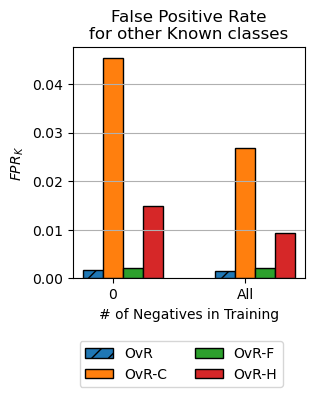

In [20]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_nt_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_nt_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_nt_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_nt_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor other Known classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_K$')
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

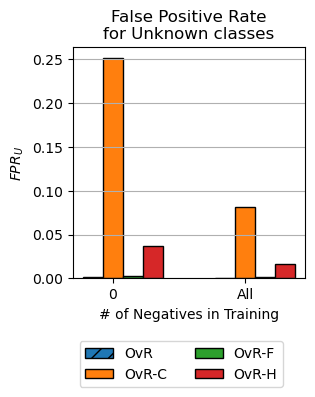

In [21]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_u_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_u_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_u_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_u_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor Unknown classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_U$')
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

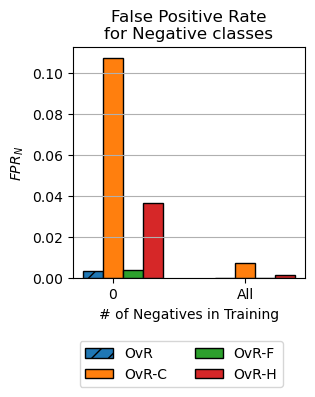

In [22]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_n_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_n_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_n_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_n_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor Negative classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_N$')
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

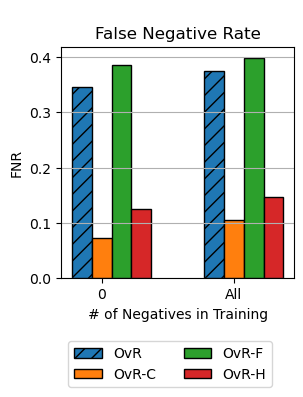

In [23]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fnr_avg'], results_all_neg['res_fpr_fnr'][0]['fnr_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fnr_avg'], results_all_neg['res_fpr_fnr'][1]['fnr_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fnr_avg'], results_all_neg['res_fpr_fnr'][2]['fnr_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fnr_avg'], results_all_neg['res_fpr_fnr'][3]['fnr_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("\nFalse Negative Rate")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FNR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

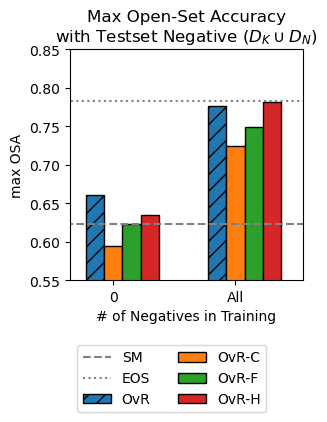

In [24]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_neg'], results_baseline['oosa'][1]['iosa_neg']]
OvR = [results_no_neg['oosa'][0]['iosa_neg'], results_all_neg['oosa'][0]['iosa_neg']]
OvR_C = [results_no_neg['oosa'][1]['iosa_neg'], results_all_neg['oosa'][1]['iosa_neg']]
OvR_F = [results_no_neg['oosa'][2]['iosa_neg'], results_all_neg['oosa'][2]['iosa_neg']]
OvR_H = [results_no_neg['oosa'][3]['iosa_neg'], results_all_neg['oosa'][3]['iosa_neg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Negative ($D_K \cup D_N$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.55, 0.85)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

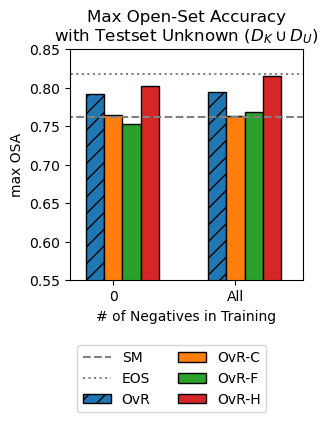

In [25]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_unkn'], results_baseline['oosa'][1]['iosa_unkn']]
OvR = [results_no_neg['oosa'][0]['iosa_unkn'], results_all_neg['oosa'][0]['iosa_unkn']]
OvR_C = [results_no_neg['oosa'][1]['iosa_unkn'], results_all_neg['oosa'][1]['iosa_unkn']]
OvR_F = [results_no_neg['oosa'][2]['iosa_unkn'], results_all_neg['oosa'][2]['iosa_unkn']]
OvR_H = [results_no_neg['oosa'][3]['iosa_unkn'], results_all_neg['oosa'][3]['iosa_unkn']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Unknown ($D_K \cup D_U$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.55, 0.85)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

#### Protocol 2

In [26]:
PROTOCOL = 2

In [27]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(eos_data_info_3[PROTOCOL-1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_baseline = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [28]:
data_info = []
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_no_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [29]:
data_info = []
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_all_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


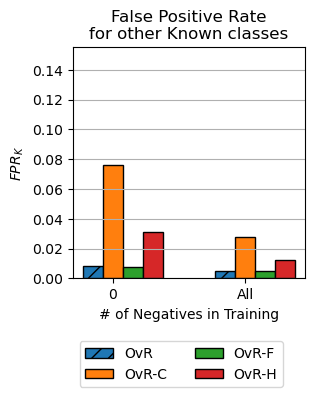

In [30]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_nt_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_nt_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_nt_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_nt_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor other Known classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_K$')
plt.ylim((0,0.155))
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

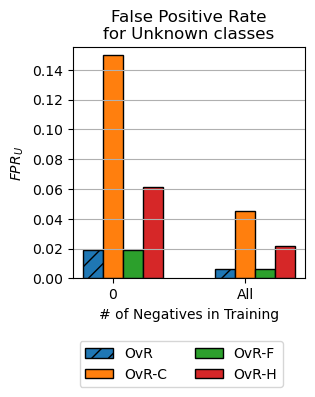

In [31]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_u_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_u_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_u_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_u_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
# Adding Xticks
plt.title("False Positive Rate\nfor Unknown classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_U$')
plt.ylim((0,0.155))
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

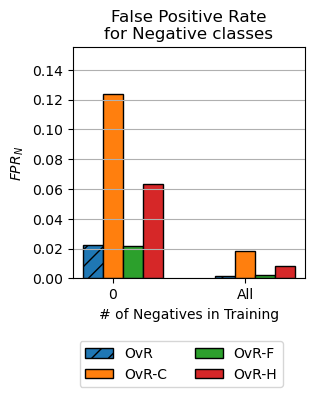

In [32]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_n_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_n_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_n_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_n_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor Negative classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('$FPR_N$')
plt.ylim((0,0.155))
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

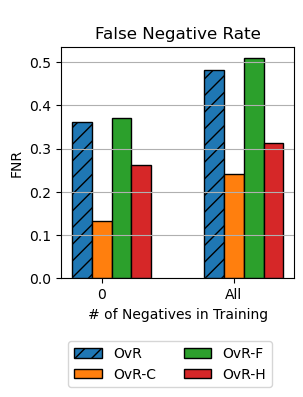

In [33]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fnr_avg'], results_all_neg['res_fpr_fnr'][0]['fnr_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fnr_avg'], results_all_neg['res_fpr_fnr'][1]['fnr_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fnr_avg'], results_all_neg['res_fpr_fnr'][2]['fnr_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fnr_avg'], results_all_neg['res_fpr_fnr'][3]['fnr_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("\nFalse Negative Rate")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FNR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

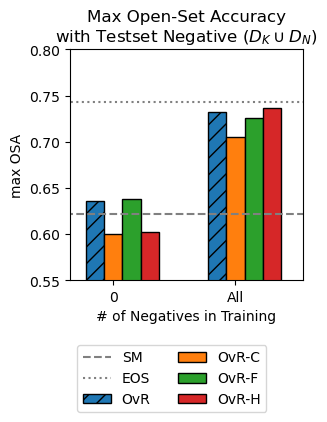

In [34]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_neg'], results_baseline['oosa'][1]['iosa_neg']]
OvR = [results_no_neg['oosa'][0]['iosa_neg'], results_all_neg['oosa'][0]['iosa_neg']]
OvR_C = [results_no_neg['oosa'][1]['iosa_neg'], results_all_neg['oosa'][1]['iosa_neg']]
OvR_F = [results_no_neg['oosa'][2]['iosa_neg'], results_all_neg['oosa'][2]['iosa_neg']]
OvR_H = [results_no_neg['oosa'][3]['iosa_neg'], results_all_neg['oosa'][3]['iosa_neg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Negative ($D_K \cup D_N$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.55, 0.8)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

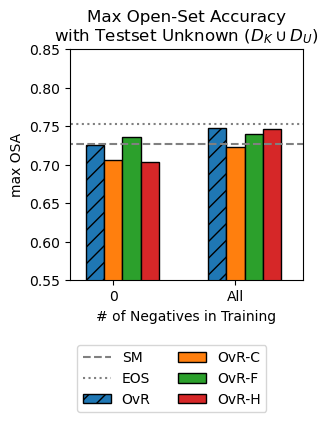

In [35]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_unkn'], results_baseline['oosa'][1]['iosa_unkn']]
OvR = [results_no_neg['oosa'][0]['iosa_unkn'], results_all_neg['oosa'][0]['iosa_unkn']]
OvR_C = [results_no_neg['oosa'][1]['iosa_unkn'], results_all_neg['oosa'][1]['iosa_unkn']]
OvR_F = [results_no_neg['oosa'][2]['iosa_unkn'], results_all_neg['oosa'][2]['iosa_unkn']]
OvR_H = [results_no_neg['oosa'][3]['iosa_unkn'], results_all_neg['oosa'][3]['iosa_unkn']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Unknown ($D_K \cup D_U$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.55, 0.85)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

#### Protocol 3

In [36]:
PROTOCOL = 3

In [37]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(eos_data_info_3[PROTOCOL-1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_baseline = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'EOS']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [38]:
data_info = []
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_no_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


In [39]:
data_info = []
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_all_neg = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']
maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


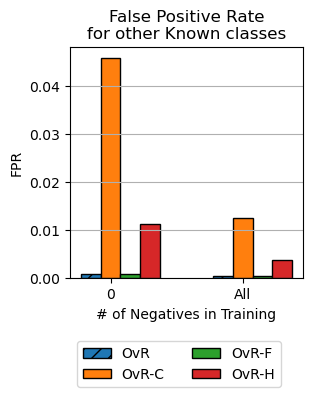

In [40]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_nt_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_nt_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_nt_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_nt_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_nt_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor other Known classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FPR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

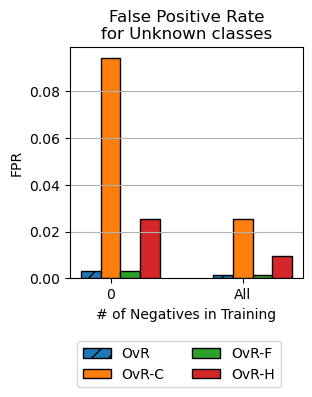

In [41]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_u_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_u_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_u_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_u_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_u_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
# Adding Xticks
plt.title("False Positive Rate\nfor Unknown classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FPR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

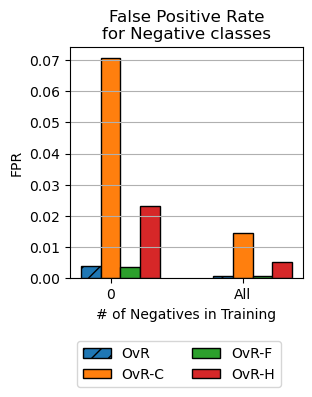

In [42]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][0]['fpr_n_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][1]['fpr_n_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][2]['fpr_n_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fpr_n_avg'], results_all_neg['res_fpr_fnr'][3]['fpr_n_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("False Positive Rate\nfor Negative classes")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FPR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

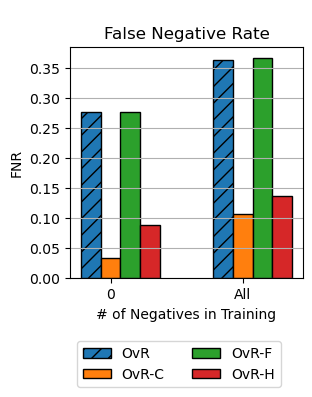

In [43]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
OvR = [results_no_neg['res_fpr_fnr'][0]['fnr_avg'], results_all_neg['res_fpr_fnr'][0]['fnr_avg']]
OvR_C = [results_no_neg['res_fpr_fnr'][1]['fnr_avg'], results_all_neg['res_fpr_fnr'][1]['fnr_avg']]
OvR_F = [results_no_neg['res_fpr_fnr'][2]['fnr_avg'], results_all_neg['res_fpr_fnr'][2]['fnr_avg']]
OvR_H = [results_no_neg['res_fpr_fnr'][3]['fnr_avg'], results_all_neg['res_fpr_fnr'][3]['fnr_avg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Adding Xticks 
plt.title("\nFalse Negative Rate")
plt.xlabel('# of Negatives in Training') 
plt.ylabel('FNR') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.grid(axis='y')
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.5), ncols=2)
plt.show()

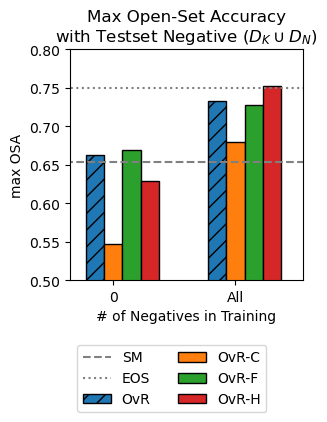

In [44]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_neg'], results_baseline['oosa'][1]['iosa_neg']]
OvR = [results_no_neg['oosa'][0]['iosa_neg'], results_all_neg['oosa'][0]['iosa_neg']]
OvR_C = [results_no_neg['oosa'][1]['iosa_neg'], results_all_neg['oosa'][1]['iosa_neg']]
OvR_F = [results_no_neg['oosa'][2]['iosa_neg'], results_all_neg['oosa'][2]['iosa_neg']]
OvR_H = [results_no_neg['oosa'][3]['iosa_neg'], results_all_neg['oosa'][3]['iosa_neg']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Negative ($D_K \cup D_N$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.5, 0.8)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

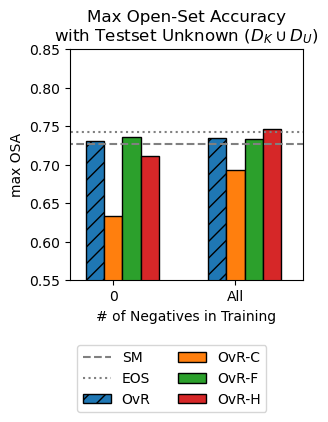

In [45]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(3,3)) 

# set height of bar 
BASE = [results_baseline['oosa'][0]['iosa_unkn'], results_baseline['oosa'][1]['iosa_unkn']]
OvR = [results_no_neg['oosa'][0]['iosa_unkn'], results_all_neg['oosa'][0]['iosa_unkn']]
OvR_C = [results_no_neg['oosa'][1]['iosa_unkn'], results_all_neg['oosa'][1]['iosa_unkn']]
OvR_F = [results_no_neg['oosa'][2]['iosa_unkn'], results_all_neg['oosa'][2]['iosa_unkn']]
OvR_H = [results_no_neg['oosa'][3]['iosa_unkn'], results_all_neg['oosa'][3]['iosa_unkn']]

# Set position of bar on X axis 
br1 = np.arange(len(OvR)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, OvR, color =CMAP_t10[0], width = barWidth, 
        edgecolor ='black', label ='OvR', hatch="//") 
plt.bar(br2, OvR_C, color =CMAP_t10[1], width = barWidth, 
        edgecolor ='black', label ='OvR-C') 
plt.bar(br3, OvR_F, color =CMAP_t10[2], width = barWidth, 
        edgecolor ='black', label ='OvR-F') 
plt.bar(br4, OvR_H, color =CMAP_t10[3], width = barWidth, 
        edgecolor ='black', label ='OvR-H') 

# Baseline
plt.hlines(BASE[0], xmin=-1, xmax=3, label='SM', linestyles='--', color='grey')
plt.hlines(BASE[1], xmin=-1, xmax=3, label='EOS', linestyles=':', color='grey')

# Adding Xticks 
plt.title('Max Open-Set Accuracy\nwith Testset Unknown ($D_K \cup D_U$)')
plt.xlabel('# of Negatives in Training') 
plt.ylabel('max OSA') 
plt.xticks([r + barWidth for r in range(len(OvR))], 
        ['0', 'All'])
plt.xlim(-0.2, 1.7)
plt.ylim(0.55, 0.85)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.6), ncols=2)
plt.show()

### OSA Plots

#### Protocol 1

In [46]:
PROTOCOL = 1

In [47]:
no_neg_data_info = []
no_neg_data_info.append(sm_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [48]:
neg_data_info = []
neg_data_info.append(eos_data_info_3[PROTOCOL-1])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


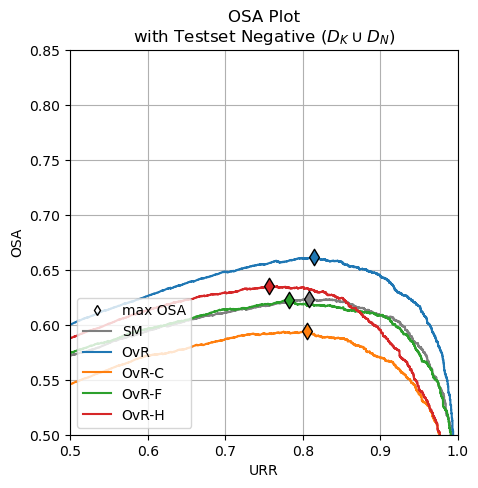

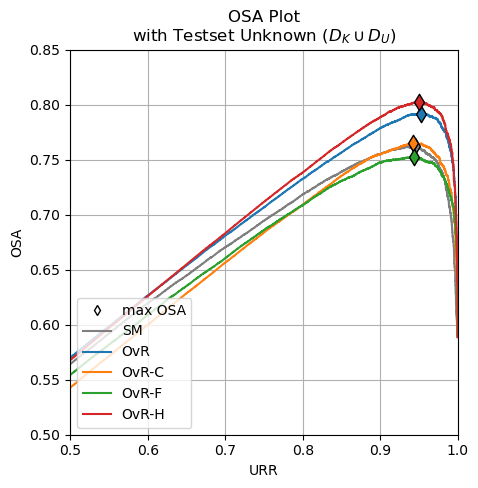

In [49]:
labels = ['SM', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(no_neg_data_info)-1]
evals.plot_OSA(no_neg_data_info, colors, labels = labels, figsize = (5,5), lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True))

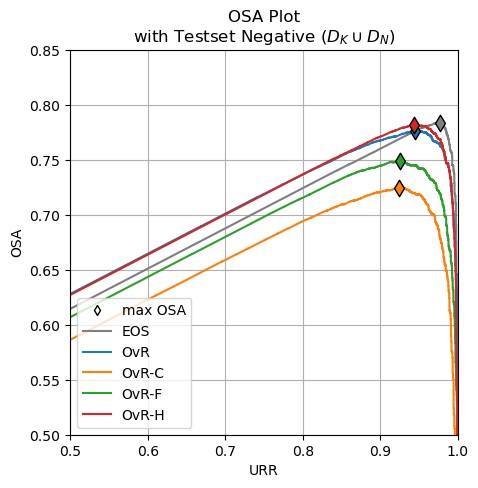

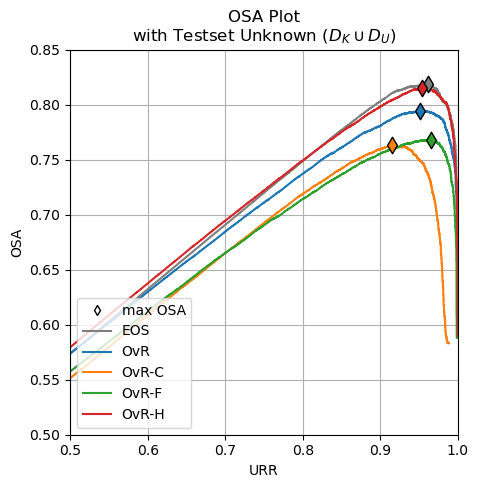

In [50]:
labels = ['EOS', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(neg_data_info)-1]
evals.plot_OSA(neg_data_info, colors, labels=labels, figsize = (5,5), lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True),)

#### Protocol 2

In [51]:
PROTOCOL = 2

In [52]:
no_neg_data_info = []
no_neg_data_info.append(sm_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [53]:
neg_data_info = []
neg_data_info.append(eos_data_info_3[PROTOCOL-1])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


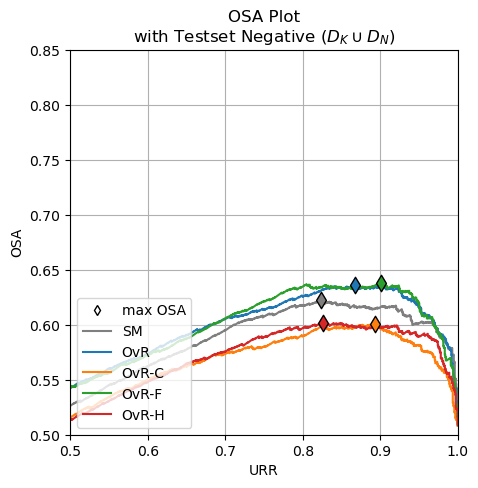

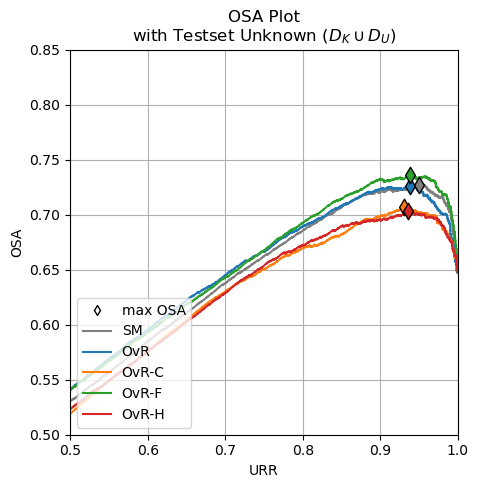

In [54]:
labels = ['SM', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(no_neg_data_info)-1]
evals.plot_OSA(no_neg_data_info, colors, labels = labels, figsize = (5,5), lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True))

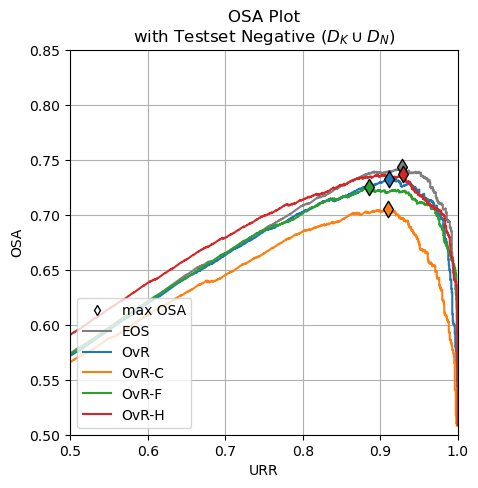

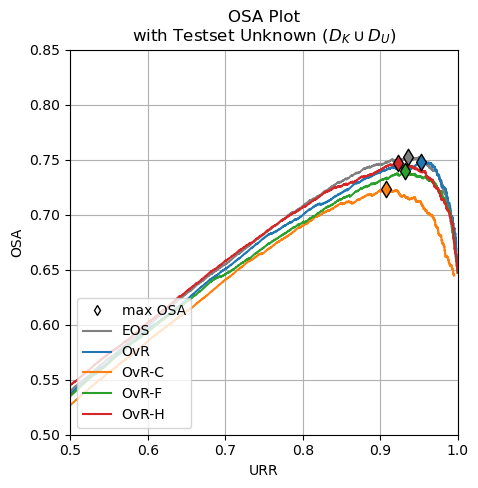

In [55]:
labels = ['EOS', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(neg_data_info)-1]
evals.plot_OSA(neg_data_info, colors, labels=labels, figsize = (5,5), lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True),)

#### Protocol 3

In [56]:
PROTOCOL = 3

In [57]:
no_neg_data_info = []
no_neg_data_info.append(sm_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [58]:
neg_data_info = []
neg_data_info.append(eos_data_info_3[PROTOCOL-1])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


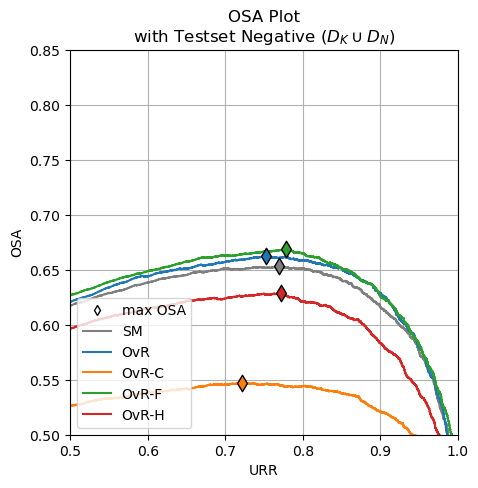

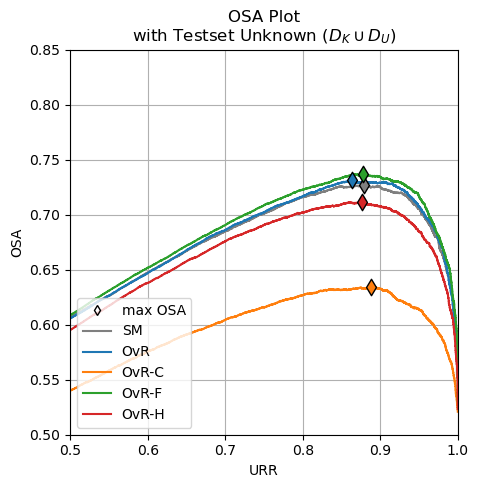

In [59]:
labels = ['SM', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(no_neg_data_info)-1]
evals.plot_OSA(no_neg_data_info, colors, labels = labels, figsize = (5,5),lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True))

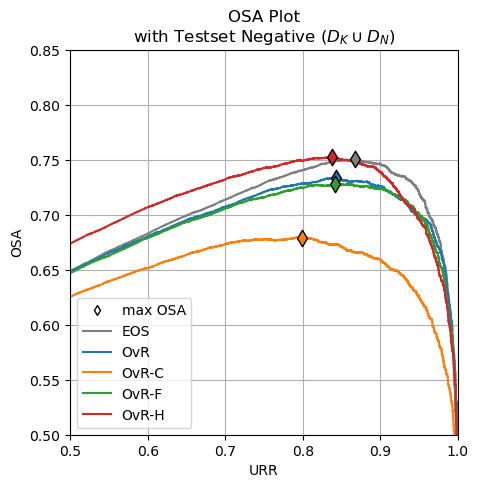

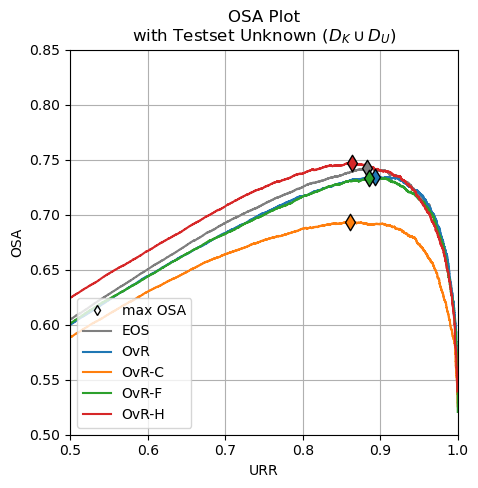

In [60]:
labels = ['EOS', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(neg_data_info)-1]
evals.plot_OSA(neg_data_info, colors, labels=labels, figsize = (5,5), lim=((0.5,1),(0.5,0.85)),
               show_point=(False, True),)

### RQ 5-1 and 2

#### Protocol 1

In [61]:
PROTOCOL = 1

In [62]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [63]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓


0.6236	0.7623	3.4966	0.0252	0.0619	0.0366
0.6613	0.7916	3.4603	0.0181	0.0365	0.0212
0.5945	0.7651	0.7293	0.4528	1.0722	2.5112
0.6226	0.7526	3.8586	0.0208	0.0404	0.0272
0.6351	0.8021	1.2603	0.1491	0.3671	0.3660


[22.36206897  2.94827586  2.          1.89655172] [52.75862069  3.03448276  2.75862069  1.67241379]
[22.72413793  2.72413793  1.98275862  1.44827586] [57.39655172  6.03448276  4.29310345  2.51724138]
[2.05172414 0.70689655 0.48275862 0.53448276] [0.84482759 0.5862069  0.29310345 0.39655172]
[12.51724138  5.03448276  3.79310345  2.89655172] [22.5862069  11.15517241  8.65517241  7.25862069]
[5.0862069  1.60344828 0.87931034 0.96551724] [8.87931034 3.01724138 1.84482759 1.48275862]


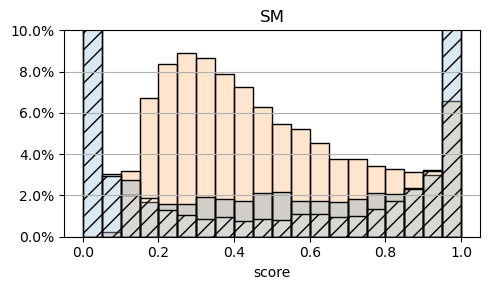

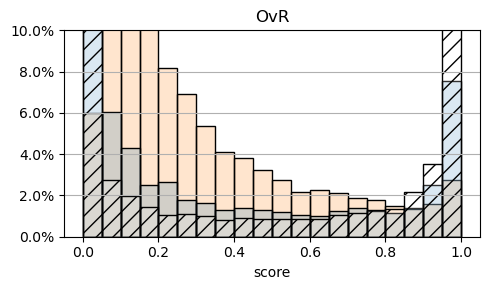

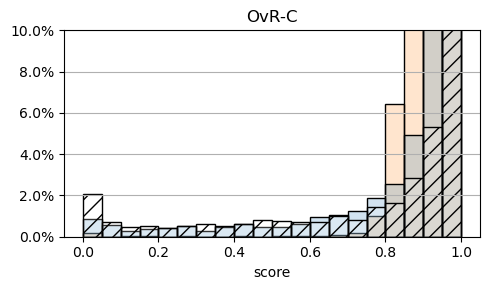

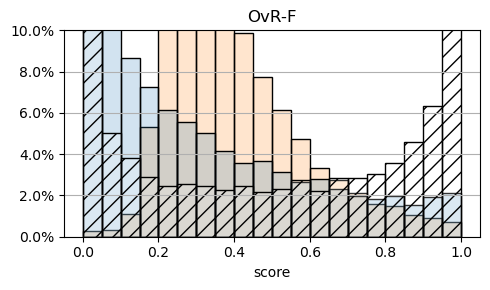

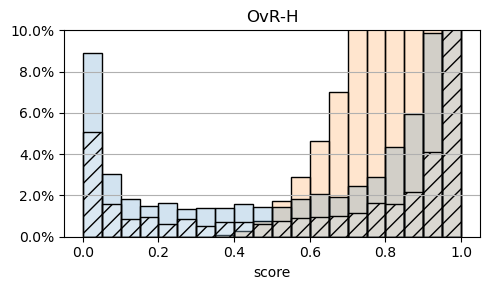

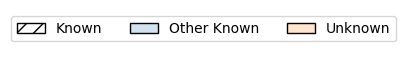

In [64]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['SM','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Known', 'Other Known', 'Negative', 'Unknown']
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 2

In [65]:
PROTOCOL = 2

In [66]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [67]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.6223	0.7273	3.6200	0.1046	0.2890	0.2641


0.6364	0.7259	3.6200	0.0814	0.2245	0.1910
0.6007	0.7066	1.3200	0.7586	1.2402	1.4962
0.6377	0.7362	3.7000	0.0772	0.2189	0.1915
0.6020	0.7033	2.6133	0.3140	0.6323	0.6160


[20.73333333  3.53333333  2.53333333  1.86666667] [50.86666667  3.73333333  2.6         1.93333333]


[19.13333333  4.33333333  2.46666667  2.8       ] [44.6         8.4         5.46666667  4.73333333]
[3.33333333 1.33333333 0.86666667 1.        ] [4.         1.46666667 1.13333333 1.86666667]
[15.86666667  4.4         2.66666667  2.46666667] [36.6         7.73333333  6.8         5.73333333]
[6.73333333 3.73333333 2.66666667 2.46666667] [13.93333333  5.6         2.73333333  2.66666667]


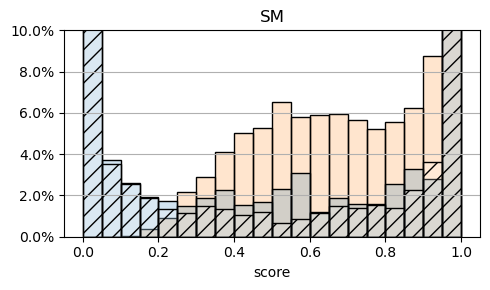

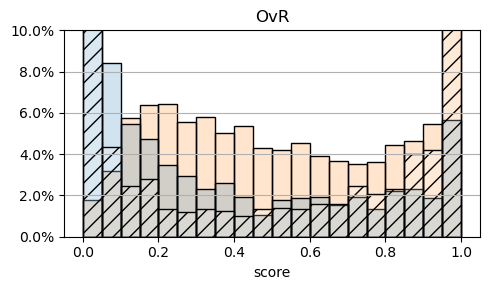

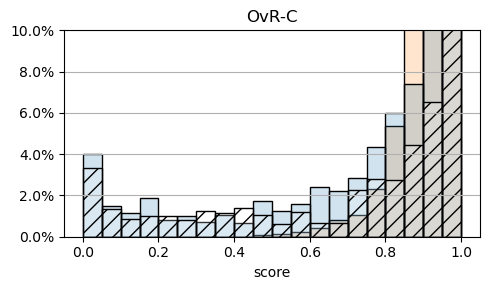

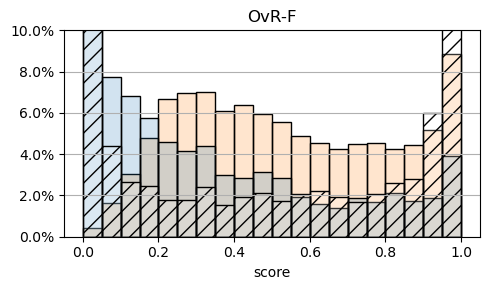

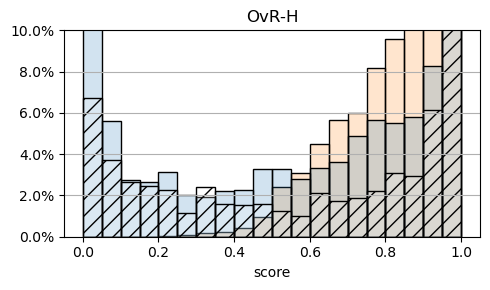

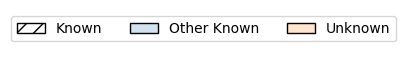

In [68]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['SM','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Known', 'Other Known', 'Negative', 'Unknown']
# legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label=labels[0], marker='+', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[1], lw=3, label=labels[1], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[2], lw=3, label=labels[2], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[3], lw=3, label=labels[3], marker='_', markeredgewidth=2),]
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 3

In [69]:
PROTOCOL = 3

In [70]:
data_info = []
data_info.append(sm_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_1[PROTOCOL-1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [71]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.6531	0.7266	2.3099	0.0133	0.0605	0.0562
0.6623	0.7314	2.7656	0.0097	0.0398	0.0339
0.5473	0.6342	0.3470	0.4583	0.7053	0.9398
0.6687	0.7367	2.7642	0.0090	0.0373	0.0310
0.6284	0.7114	0.8848	0.1126	0.2327	0.2551


[16.50331126  1.36423841  0.95364238  0.91390728] [69.41721854  2.18543046  1.66887417  1.05960265]
[20.71523179  1.82781457  1.08609272  0.63576159] [71.82781457  4.31788079  2.43708609  1.8807947 ]
[0.63576159 0.25165563 0.25165563 0.37086093] [2.17218543 0.67549669 0.58278146 0.35761589]
[14.84768212  2.90066225  2.          1.60264901] [57.8410596   8.90066225  4.84768212  3.86754967]
[3.16556291 0.94039735 0.79470199 0.76821192] [14.33112583  2.80794702  2.02649007  1.7615894 ]


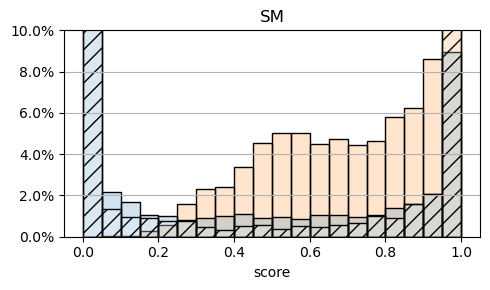

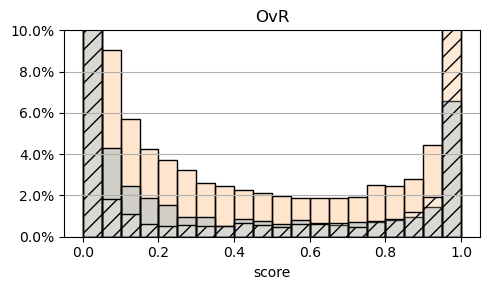

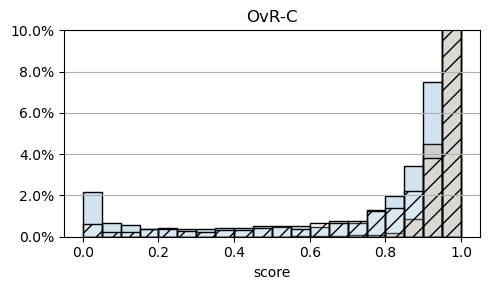

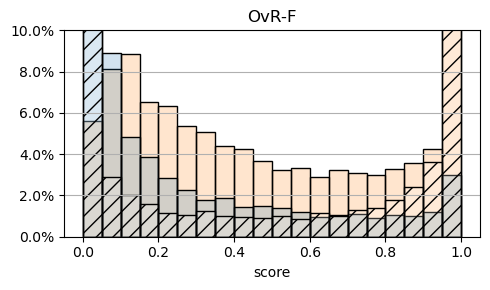

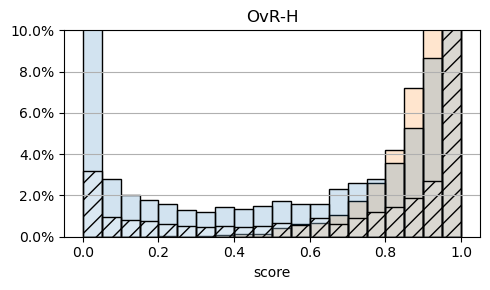

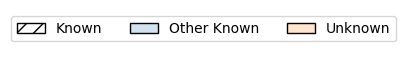

In [72]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['SM','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Known', 'Other Known', 'Negative', 'Unknown']
# legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label=labels[0], marker='+', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[1], lw=3, label=labels[1], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[2], lw=3, label=labels[2], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[3], lw=3, label=labels[3], marker='_', markeredgewidth=2),]
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### RQ 5-3 and 4

#### Protocol 1

In [73]:
PROTOCOL = 1

In [74]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [75]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.7835	0.8184	3.4103	0.0219	0.0014	0.0071
0.7758	0.7947	3.7431	0.0151	0.0014	0.0105
0.7247	0.7634	1.0586	0.2683	0.0775	0.8137
0.7489	0.7682	3.9759	0.0206	0.0029	0.0211
0.7815	0.8152	1.4759	0.0926	0.0151	0.1609


[21.55172414  2.94827586  1.62068966  1.5       ] [54.32758621  4.17241379  3.06896552  2.44827586]
[25.94827586  2.9137931   1.5         1.4137931 ] [64.75862069  5.48275862  3.34482759  2.27586207]
[4.87931034 1.0862069  0.72413793 0.68965517] [3.89655172 1.34482759 0.94827586 0.94827586]
[4.01724138 3.9137931  4.0862069  3.75862069] [4.62068966 6.72413793 7.29310345 9.43103448]
[8.43103448 1.15517241 0.77586207 0.77586207] [20.01724138  4.03448276  2.5         2.06896552]


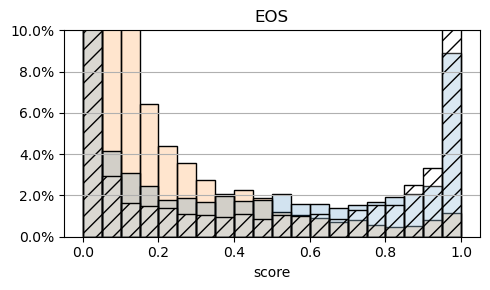

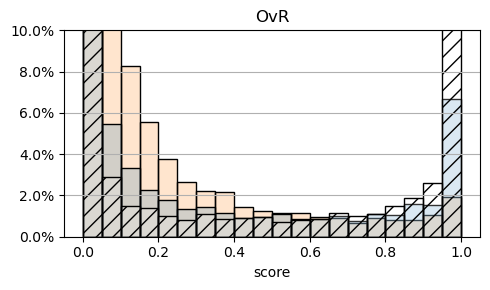

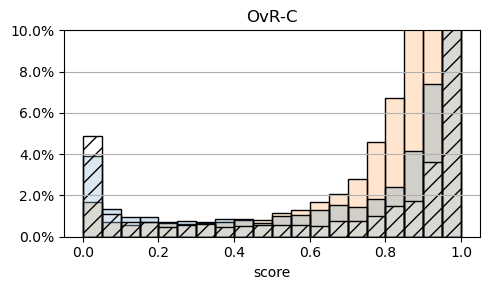

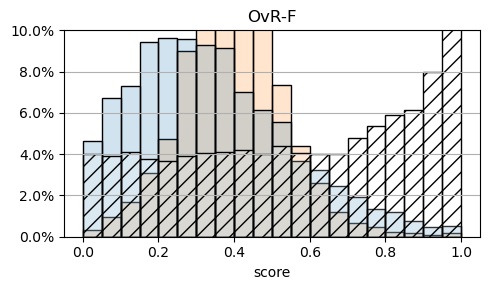

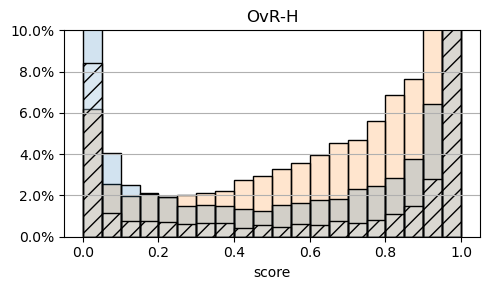

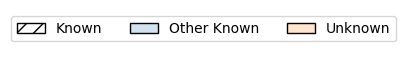

In [76]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['EOS','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Known', 'Other Known', 'Negative', 'Unknown']
# legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label=labels[0], marker='+', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[1], lw=3, label=labels[1], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[2], lw=3, label=labels[2], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[3], lw=3, label=labels[3], marker='_', markeredgewidth=2),]
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 2

In [77]:
PROTOCOL = 2

In [78]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [79]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.7433	0.7527	4.5133	0.0586	0.0234	0.0720
0.7325	0.7478	4.8200	0.0506	0.0194	0.0615
0.7056	0.7231	2.4067	0.2761	0.1822	0.4539
0.7256	0.7395	5.0800	0.0490	0.0200	0.0615
0.7367	0.7468	3.1200	0.1264	0.0815	0.2200


[21.73333333  6.          4.2         2.66666667] [48.46666667 13.26666667  5.46666667  4.06666667]
[34.13333333  3.46666667  1.66666667  1.86666667] [67.73333333  5.93333333  3.06666667  1.66666667]
[12.13333333  2.46666667  1.33333333  1.6       ] [19.73333333  5.13333333  3.6         2.53333333]
[4.8        6.66666667 5.66666667 5.2       ] [ 6.53333333 12.66666667 12.4        10.93333333]
[18.86666667  2.46666667  1.73333333  1.53333333] [45.73333333  6.6         4.06666667  2.86666667]


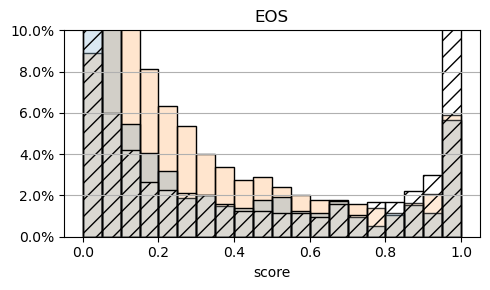

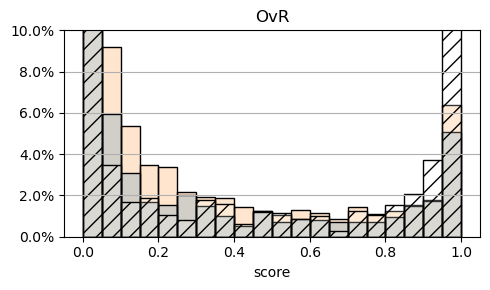

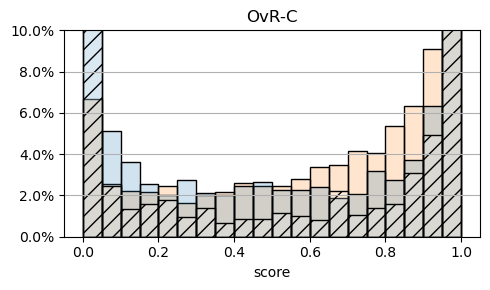

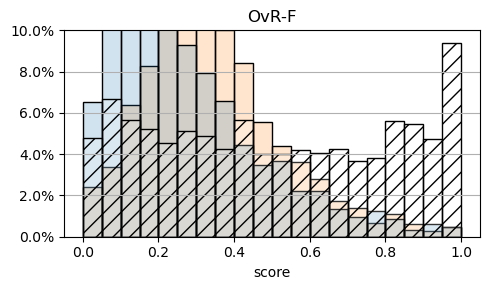

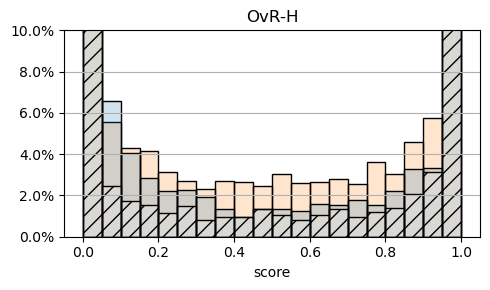

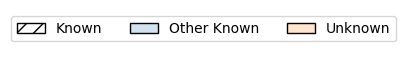

In [80]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['EOS','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Known', 'Other Known', 'Negative', 'Unknown']
# legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label=labels[0], marker='+', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[1], lw=3, label=labels[1], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[2], lw=3, label=labels[2], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[3], lw=3, label=labels[3], marker='_', markeredgewidth=2),]
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

#### Protocol 3

In [81]:
PROTOCOL = 3

In [82]:
data_info = []
data_info.append(eos_data_info_3[PROTOCOL-1])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'EOS']
['LargeScale_3', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [83]:
results = evals.print_metrics(data_info)

maxOSA_N↑	maxOSA_U↑	FNR(1e-1)↓	FPR(NT)↓	FPR(N)↓	FPR(U)↓
0.7502	0.7420	3.3364	0.0067	0.0082	0.0166
0.7335	0.7343	3.6397	0.0056	0.0080	0.0144
0.6793	0.6935	1.0702	0.1269	0.1457	0.2529
0.7281	0.7334	3.6623	0.0059	0.0082	0.0145
0.7522	0.7471	1.3682	0.0392	0.0520	0.0971


[20.2781457   3.54966887  1.93377483  1.64238411] [71.36423841  6.05298013  3.15231788  2.17218543]
[27.33774834  2.21192053  1.52317881  0.98013245] [80.91390728  3.8807947   1.69536424  1.31125828]
[4.84768212 1.13907285 0.80794702 0.74172185] [15.82781457  2.35761589  1.90728477  1.21854305]
[4.87417219 4.63576159 3.82781457 3.74834437] [18.0397351  14.62251656 12.37086093 10.99337748]
[7.7218543  1.39072848 0.96688742 0.66225166] [38.63576159  4.76821192  3.08609272  2.43708609]


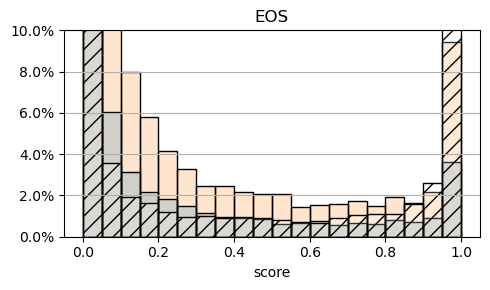

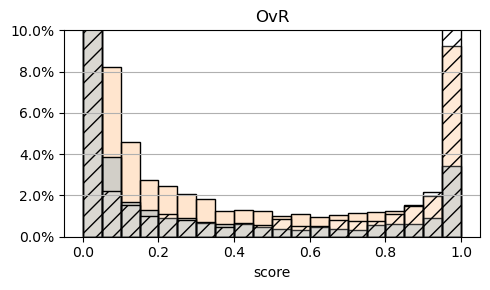

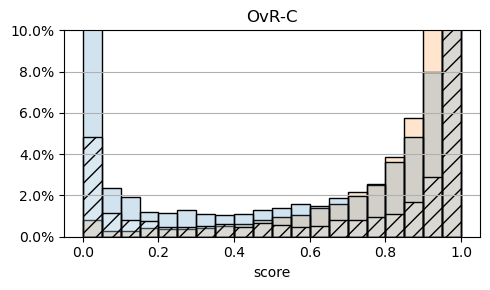

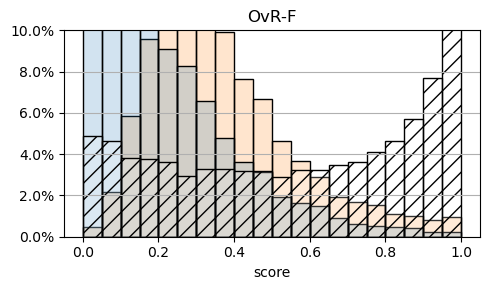

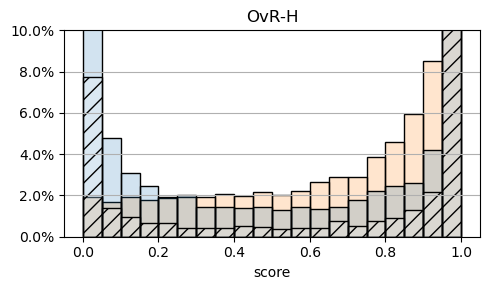

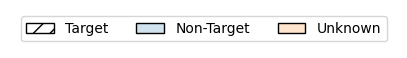

In [84]:
start, stop, step = 0, 1, 0.05
# colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
colors=('white',CMAP_t10[0],CMAP_t10[2],CMAP_t10[1])
alpha = [0.2]*len(colors)
colors = list(zip(colors,alpha))
title = ['EOS','OvR','OvR-C','OvR-F','OvR-H']
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, title=title,
                               figsize=(5,3), ylim=(0,10), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-Target', 'Negative', 'Unknown']
# legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label=labels[0], marker='+', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[1], lw=3, label=labels[1], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[2], lw=3, label=labels[2], marker='_', markeredgewidth=2),
#                   Line2D([0], [0], color=colors[3], lw=3, label=labels[3], marker='_', markeredgewidth=2),]
legend_elements = [Patch(facecolor=colors[0], label=labels[0], edgecolor='black', hatch='//'),
                  Patch(facecolor=colors[1], label=labels[1], edgecolor='black'),
                #   Patch(facecolor=colors[2], label=labels[2], edgecolor='black'),
                  Patch(facecolor=colors[3], label=labels[3], edgecolor='black'),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### Appendix

In [85]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [86]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

In [87]:
# PROTOCOL = 1

# log_item = log_item_list[ITEM_IDX][0]
# y_axis_name = log_item_list[ITEM_IDX][1]
# plot_title = log_item_list[ITEM_IDX][2]

# data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
# data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
# data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

# plt.figure(figsize=(10,5))
# for idx, d_i in enumerate(data_info):

#     logs = evals.get_training_log(d_i, log_item)

#     plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
#     plt.ylim((-0.1,1.1))
#     plt.ylabel(y_axis_name)
#     plt.xlabel('epochs')
#     plt.title(plot_title)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tick_params(direction='in')


#### Protocol 2

In [88]:
# PROTOCOL = 2

# log_item = log_item_list[ITEM_IDX][0]
# y_axis_name = log_item_list[ITEM_IDX][1]
# plot_title = log_item_list[ITEM_IDX][2]

# data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
# data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
# data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1][-1:]

# plt.figure(figsize=(10,5))
# for idx, d_i in enumerate(data_info):

#     logs = evals.get_training_log(d_i, log_item)

#     plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
#     plt.ylim((-0.1,1.1))
#     plt.ylabel(y_axis_name)
#     plt.xlabel('epochs')
#     plt.title(plot_title)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tick_params(direction='in')


#### Protocol 3

In [89]:
# PROTOCOL = 3

# log_item = log_item_list[ITEM_IDX][0]
# y_axis_name = log_item_list[ITEM_IDX][1]
# plot_title = log_item_list[ITEM_IDX][2]

# data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
# data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
# data_info += dsovr_data_info_2[PROTOCOL-1] + dsovr_data_info_3_C[PROTOCOL-1]

# plt.figure(figsize=(10,5))
# for idx, d_i in enumerate(data_info):

#     logs = evals.get_training_log(d_i, log_item)

#     plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
#     plt.ylim((-0.1,1.1))
#     plt.ylabel(y_axis_name)
#     plt.xlabel('epochs')
#     plt.title(plot_title)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tick_params(direction='in')
